In [ ]:
# default_exp background_distributions

In [ ]:
#export
class ConditionBackgrounds():

    def __init__(self, normed_condition_df):
        self.backgrounds = []
        self.normed_condition_df = normed_condition_df
        self.ion2background = {}
        self.ion2nonNanvals = {}
        self.init_ion2nonNanvals(self.normed_condition_df)
        self.select_intensity_ranges()

    def init_ion2nonNanvals(self, normed_condition_df):
        for peptide, vals in normed_condition_df.iterrows():
            self.ion2nonNanvals[peptide] = vals[vals.notna()].values


    def select_intensity_ranges(self):
        total_available_comparisons =0
        num_contexts = 100
        cumulative_counts = np.zeros(self.normed_condition_df.shape[0])

        for idx ,count in enumerate(self.normed_condition_df.count(axis=1)):
            total_available_comparisons+=count-1
            cumulative_counts[idx] = int(total_available_comparisons/2)
        
        
        #assign the context sizes
        context_size = np.max([1000, int(total_available_comparisons/(1+num_contexts/2))])
        halfcontext_size = int(context_size/2)
        context_boundaries = np.zeros(3).astype(int)

        middle_idx = int(np.searchsorted(cumulative_counts, halfcontext_size))
        end_idx = int(np.searchsorted(cumulative_counts, context_size))


        context_boundaries[0] = 0
        context_boundaries[1] = middle_idx
        context_boundaries[2] = end_idx
        while context_boundaries[1] < len(cumulative_counts)-1:
            bgdist = BackGroundDistribution(context_boundaries[0], context_boundaries[2], self.ion2nonNanvals)
            assign_ions2bgdists(context_boundaries[0], context_boundaries[2], bgdist)
            self.backgrounds.append(bgdist)
            context_boundaries[0] = context_boundaries[1]
            context_boundaries[1] = context_boundaries[2]
            end_idx = np.searchsorted(cumulative_counts, context_size + cumulative_counts[context_boundaries[0]])
            if end_idx > len(cumulative_counts)-(context_boundaries[1]-context_boundaries[0])/1.5:
                end_idx = len(cumulative_counts)-1
            context_boundaries[2] = end_idx

    def assign_ions2bgdists(boundaries1, boundaries2,bgdist):
        ion2bg_local = dict(map(lambda _idx : (self.normed_condition_df.iloc[_idx, 0], bgdist), range(boundaries1, boundaries2)))
        self.ion2background.update(ion2bg_local)


In [ ]:
#export
import numpy as np
from random import shuffle
import pandas as pd
from scipy.stats import norm
import math

class BackGroundDistribution:

    fc_resolution_factor = 100
    fc_conversion_factor = 1/fc_resolution_factor

    def __init__(self, start_idx, end_idx, idx2noNanvals):
        self.fc2counts = {} #binned Fold change Distribution
        self.cumulative = np.array([])
        self.zscores = np.array([])
        self.min_fc =0
        self.max_fc = 0
        self.min_z=0
        self.max_z=0
        self.start_idx = int(start_idx)
        self.end_idx = int(end_idx)
        self.var = None
        self.SD = None

        anchor_fcs = self.generate_anchorfcs_from_intensity_range(idx2noNanvals)
        shuffle(anchor_fcs)
        self.generate_fc2counts_from_anchor_fcs(anchor_fcs)
        self.cumulative = self.transform_fc2counts_into_cumulative()
        self.calc_SD(0, self.cumulative)
        self.zscores = self.transform_cumulative_into_z_values()

    def generate_anchorfcs_from_intensity_range(self,idx2noNanvals):
        anchor_fcs = []
        for idx in range(self.start_idx, self.end_idx):
           # print(f"start {self.start_idx} end {self.end_idx}")
            vals = idx2noNanvals[idx]
            if vals.size < 2:
                continue
            anchor_idx =  np.random.randint(0, len(vals))
            anchor_val = vals[anchor_idx]
            vals = np.delete(vals, anchor_idx)
            anchor_fcs.extend(vals-anchor_val)
        return anchor_fcs


    def generate_fc2counts_from_anchor_fcs(self,anchor_fcs):
        
        anchor_fcs = np.array(anchor_fcs)
        for idx in range(1, anchor_fcs.shape[0]):
            fc_binned = np.rint(self.fc_resolution_factor*(0.5*(anchor_fcs[idx-1] - anchor_fcs[idx]))).astype(np.long)
            self.fc2counts[fc_binned] = self.fc2counts.setdefault(fc_binned, 0) + 1

        self.min_fc = min(self.fc2counts.keys())
        self.max_fc = max(self.fc2counts.keys())

    
    def transform_fc2counts_into_cumulative(self):
        
        cumulative = np.zeros(self.max_fc - self.min_fc +1).astype(np.long)

        for entry in self.fc2counts.items():
            cumulative[int(entry[0]-self.min_fc)] +=entry[1]
        for idx in range(1,cumulative.shape[0]):
            cumulative[idx] +=cumulative[idx-1]
        
        return cumulative

    
    def transform_cumulative_into_z_values(self):
        total = self.cumulative[-1]
        min_pval = 1/(total+1)
        self.max_z = abs(norm.ppf(max(1e-9, min_pval)))
        zscores = np.zeros(len(self.cumulative))
        zero_pos = -self.min_fc

        normfact_posvals = 1/(total-self.cumulative[zero_pos]+1)
        normfact_negvals = 1/(self.cumulative[zero_pos-1]+1)
        for i in range(len(self.cumulative)):
            num_more_extreme = 0
            if i == zero_pos:
                zscores[i] = 0
                continue
            if i!=zero_pos and i<len(self.cumulative)-1:
                num_more_extreme = self.cumulative[i] if i<zero_pos else  self.cumulative[-1] - self.cumulative[i+1]
            
            normfact = normfact_negvals if i<zero_pos else normfact_posvals
            p_val = 0.5*max(1e-9, (num_more_extreme+1)*normfact)
            sign = -1 if i<zero_pos else 1
            zscores[i] = sign*norm.ppf(p_val) ##ppf is the inverese cumulative distribution function

        return zscores


    def calc_zscore_from_fc(self, fc):
        if abs(fc)<1e-9:
            return 0
        k = int(fc * self.fc_resolution_factor)
        rank = k-self.min_fc
        if rank <0:
            return -self.max_z
        if rank >=len(self.cumulative):
            return self.max_z
        print(rank)
        return self.zscores[rank]


    def calc_SD(self, mean, cumulative):
        sq_err = 0.0
        previous =0
        for i in range(len(cumulative)):
            fc = (i+self.min_fc)*self.fc_conversion_factor
            sq_err += (cumulative[i] - previous)*(fc-mean)**2
            previous = cumulative[i]
        total = cumulative[-1]
        var = sq_err/total
        self.var = var
        self.SD = math.sqrt(var)



In [ ]:
#export
#subtract two Empirical Backgrounds
from scipy.stats import norm
class SubtractedBackgrounds(BackGroundDistribution):

    def __init__(self, from_dist, to_dist):
        self.max_fc = None
        self.min_fc = None
        self.var_from = from_dist.var
        self.var_to = to_dist.var
        self.cumulative = None
        self.subtract_distribs(from_dist, to_dist)
        self.fc2counts = transform_cumulative_into_fc2count(self.cumulative,self.min_fc)
        self.calc_SD(0, self.cumulative)
        self.zscores = self.transform_cumulative_into_z_values()
        
    def subtract_distribs(self,from_dist, to_dist):
        min_joined = from_dist.min_fc - to_dist.max_fc
        max_joined = from_dist.max_fc - to_dist.min_fc

        n_from = get_normed_freqs(from_dist.cumulative)
        n_to = get_normed_freqs(to_dist.cumulative)

        min_from = from_dist.min_fc
        min_to = to_dist.min_fc

        joined = np.zeros(max_joined-min_joined+1, dtype="long")
        
        count_comparisons =0
        for from_idx in range(len(n_from)):
            fc_from = min_from + from_idx
            freq_from = n_from[from_idx]
            for to_idx in range(len(n_to)):
                fc_to = min_to + to_idx
                freq_to = n_to[to_idx]
                fcdiff = fc_from - fc_to
                joined_idx = fcdiff - min_joined
                freq_multiplied = freq_from*freq_to
                joined[joined_idx] += (freq_multiplied)
                count_comparisons+=1
        self.max_fc = max_joined
        self.min_fc = min_joined
        self.cumulative = get_cumul_from_freq(joined)



In [ ]:
#hide

def test_subtract_distribs():
    from_dist = [1,1,2,1,1]
    to_dist = [1,1,2,1,1]

In [ ]:
#export
def get_subtracted_bg(ion2diffDist, bg1, bg2, ion):
    if ion in ion2diffDist.keys():
        return ion2diffDist.get(ion)
    subtr_bg = SubtractedBackgrounds(condbg1, condbg2)
    ion2diffDist.update({ion : subtr_bg})

In [ ]:
#export
#get normalized freqs from cumulative

def get_normed_freqs(cumulative):
    normfact = 1e5 /cumulative[-1]
    freqs =get_freq_from_cumul(cumulative)
    for i in range(len(freqs)):
        freqs[i] *= normfact
    return freqs



In [ ]:
#export
#transform cumulative into frequency

def get_freq_from_cumul(cumulative):
    res = np.zeros(len(cumulative), dtype="long")
    res[0] = cumulative[0]
    for i in range(1,len(cumulative)):
        res[i] = cumulative[i]-cumulative[i-1]

    return res


In [ ]:
#export
def transform_cumulative_into_fc2count(cumulative, min_fc):
    res = {}
    for idx in range(1, len(cumulative)):
        fc = idx + min_fc
        res[fc] = cumulative[idx] - cumulative[idx-1]
    return res


In [ ]:
#export
def get_cumul_from_freq(freq):
    res = np.zeros(len(freq), dtype="long")
    res[0] = freq[0]
    for i in range(1,len(freq)):
        res[i] = res[i-1] + freq[i]

    return res


, -1.32109916]), 1627: array([-0.96638585,  1.44760598, -1.09392927]), 1628: array([0.65744307, 0.21424017, 0.91469609]), 1629: array([-1.78569607, -0.25390914, -0.23603047]), 1630: array([ 1.5753368 , -1.12314308,  0.43586907]), 1631: array([0.10700065, 2.49317778, 1.28531297]), 1632: array([-1.21078244,  0.03598078, -1.14252115]), 1633: array([ 1.49962916, -0.57417605, -1.35416949]), 1634: array([-0.93148371, -0.01543334,  1.33963028]), 1635: array([-0.07416806,  1.18323107, -2.70341646]), 1636: array([0.44352877, 1.2790522 , 0.06499469]), 1637: array([ 0.49807198, -0.14913611,  0.74913077]), 1638: array([ 0.11823518, -1.73124814, -0.654909  ]), 1639: array([ 0.19016953, -0.12356854, -0.98529523]), 1640: array([-0.03838389, -0.22139314,  1.81039499]), 1641: array([-0.64618089,  0.30246131, -0.02105003]), 1642: array([0.95048114, 1.75226111, 1.01210721]), 1643: array([ 0.50787372,  0.12922405, -1.79138879]), 1644: array([-0.21875135,  0.30222106, -1.4205899 ]), 1645: array([-0.2599194

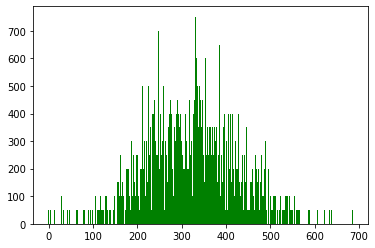

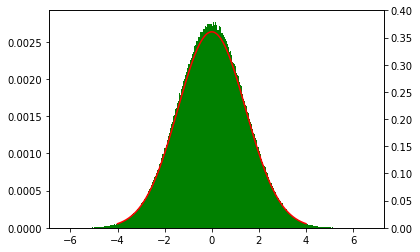

In [ ]:
#hide
#test subtract background distribution
from scipy.stats import norm
import matplotlib.pyplot as plt

idx2nonnanvals = {}

for idx in range(2000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    
bgdist1 = BackGroundDistribution(0, 999, idx2nonnanvals)
bgdist2 = BackGroundDistribution(1000, 1999, idx2nonnanvals)

freqdist = get_normed_freqs(bgdist1.cumulative)
plt.bar(range(len(freqdist)),freqdist,width=1,color='g')
plt.show()

subtracted_bgs = SubtractedBackgrounds(bgdist1, bgdist2)

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales

fc2counts_rescaled = tranform_fc2count_to_fc_space(subtracted_bgs.fc2counts, subtracted_bgs.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g')
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, subtracted_bgs.SD)*1.3, color = "red")
axes2.set_ylim(0.0, 0.4)
plt.show()



107,  0.68356586]), 99634: array([ 0.43714058, -0.4364919 , -0.25328138]), 99635: array([ 0.26078364, -1.62113853, -1.09972063]), 99636: array([0.82687613, 0.44976736, 0.36443765]), 99637: array([-1.41936326, -2.41186889, -0.27048929]), 99638: array([1.58837567, 1.14774004, 1.83221983]), 99639: array([0.01582366, 0.65618305, 0.37627933]), 99640: array([0.77239597, 0.26909297, 1.69981831]), 99641: array([ 0.93703541, -0.95532599,  1.57776778]), 99642: array([-0.87486634, -2.60951852,  0.98741136]), 99643: array([0.26338098, 1.12212703, 1.36935592]), 99644: array([-0.03279503,  0.72411636,  0.81858686]), 99645: array([ 0.72344434, -0.25312992,  0.5022096 ]), 99646: array([-1.20554356, -0.43416494,  1.20388359]), 99647: array([-1.42913786,  1.32147973, -0.51818533]), 99648: array([0.26706943, 0.15626211, 1.56231805]), 99649: array([ 0.03448081,  1.29637129, -1.75849349]), 99650: array([ 0.66088548, -0.23463178,  1.59988861]), 99651: array([0.66551332, 0.92659891, 0.07630848]), 99652: arra

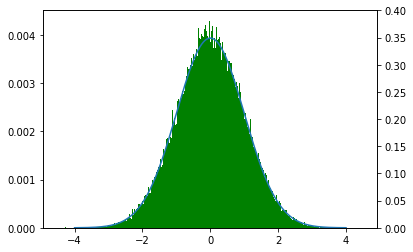

In [ ]:
#hide
#test background distribution
from scipy.stats import norm
import matplotlib.pyplot as plt

idx2nonnanvals = {}

for idx in range(100000):
    nonnanvals =  np.random.normal(loc=0, size=3)
    idx2nonnanvals[idx] = nonnanvals
    
bgdist = BackGroundDistribution(0, 99999, idx2nonnanvals)

def tranform_fc2count_to_fc_space(fc2counts, num_fcs, rescale_factor):
    fc2counts_fcscales = {}
    for fc, count in fc2counts.items():
        fc2counts_fcscales[fc*rescale_factor] = count/num_fcs

    return fc2counts_fcscales

fc2counts_rescaled = tranform_fc2count_to_fc_space(bgdist.fc2counts, bgdist.cumulative[-1],1/100.0)

plt.bar(list(fc2counts_rescaled.keys()), fc2counts_rescaled.values(),width=0.01,color='g',)
axes2 = plt.twinx()
x = np.linspace(-4, 4, 1000)
axes2.plot(x, norm.pdf(x, 0, bgdist.SD)/1.15)
axes2.set_ylim(0.0, 0.4)
plt.show()




